In [1]:
import os
import subprocess
from Tools.evalute_model import *

In [2]:
train_x_file_path='Parabel/dataset/train_feat.txt'
train_y_file_path='Parabel/dataset/train_label.txt'

test_x_file_path='Parabel/dataset/test_feat.txt'
test_y_file_path='Parabel/dataset/test_label.txt'

model_dir='Parabel/output'
pred_y_file_path='Parabel/output/output_scores.txt'
pred_train_y_file_path='Parabel/output/train_output_scores.txt'


noise_train_x_file_path='Parabel/dataset/noise_train_feat.txt'
noise_test_x_file_path='Parabel/dataset/noise_test_feat.txt'
model_noise_dir='Parabel/output_noise'

base_pred_y_noise_file_path='Parabel/output_noise/base_output_scores.txt'
pred_y_noise_file_path='Parabel/output_noise/output_scores.txt'


In [14]:
import numpy as np

def load_parabel_sparse_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    shape_line = lines[0]
    num_rows, num_cols = map(int, shape_line.strip().split())

    data = []
    row_idx = []
    col_idx = []

    for i, line in enumerate(lines[1:]):
        tokens = line.strip().split()
        for tok in tokens:
            if ":" in tok:
                col, val = tok.split(":")
                col = int(col)
                val = float(val)
                row_idx.append(i)
                col_idx.append(col)
                data.append(val)
    return (np.array(data), np.array(row_idx), np.array(col_idx), (num_rows, num_cols))

def save_parabel_sparse_file(data, row_idx, col_idx, shape, file_path):
    from collections import defaultdict
    row_data = defaultdict(list)
    for val, row, col in zip(data, row_idx, col_idx):
        row_data[row].append((col, val))

    with open(file_path, 'w') as f:
        f.write(f"{shape[0]} {shape[1]}\n")
        for i in range(shape[0]):
            entries = row_data[i]
            entries.sort()  # sort by column index
            line = " ".join([f"{col}:{val:.6f}" for col, val in entries])
            f.write(line + "\n")

def add_gaussian_noise(data, mean, std):
    noisy_data = data + np.random.normal(mean, std, size=data.shape)
    return noisy_data


In [15]:
x_test_data, x_test_row, x_test_col, shape = load_parabel_sparse_file(test_x_file_path)
x_test_data_noise = add_gaussian_noise(x_test_data,mean=0.0, std=0.5)
save_parabel_sparse_file(x_test_data_noise, x_test_row, x_test_col, shape, noise_test_x_file_path)


In [16]:
# testing the model
command = [
    "./Parabel/binaries/Linux/parabel_predict",     # Ensure binary is compiled and accessible
    noise_test_x_file_path,
    model_dir,
    base_pred_y_noise_file_path,
    "-T", "4",               # Number of threads
    "-s", "0",               # Start tree
    "-t", "3",               # Number of trees
    "-B", "10",              # Beam width
    "-q", "0"                # Verbosity
]

test_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(test_result.stdout)
print("Testing complete")

tree ree 1 predicting started0 predicting started
tree ree 1 predicting started0 predicting started
 predicting started
node 0
node 0
node 0
node 100
node 100
node 100
tree 1 predicting completed
tree 0 predicting completed
tree 2 predicting completed
prediction time: 1.25197 ms/point
model size: 0.0259221 GB

Testing complete


In [ ]:
avg_precision_base, avg_ndcg_base = evaluate_metrics(test_y_file_path, base_pred_y_noise_file_path)


print("Evaluation Metrics (k = 1 to 10):\n")
print(f"{'k':<4} {'Precision@k':<10} {'nDCG@k':<10}")
print("-" * 34)

for k in range(1, 11):
    print(f"{k:<4} {avg_precision_base[k]*100:<10.2f} {avg_ndcg_base[k]*100:<10.2f}")

Evaluation Metrics (k = 1 to 10):

k    Precision@k nDCG@k    
----------------------------------
1    78.70      78.70     
2    71.45      73.11     
3    65.34      68.77     
4    59.48      65.21     
5    54.07      63.07     
6    48.92      62.47     
7    44.29      64.00     
8    40.26      65.32     
9    36.74      66.37     
10   33.68      67.22     


# Making the model more robust

In [4]:
# === Load, perturb and save ===
x_data, x_row, x_col, shape = load_parabel_sparse_file(train_x_file_path)
x_data_noisy = add_gaussian_noise(x_data, mean=0.0, std=0.01)
save_parabel_sparse_file(x_data_noisy, x_row, x_col, shape, noise_train_x_file_path)


In [5]:
# training the model
if not os.path.exists(model_noise_dir):
    os.makedirs(model_noise_dir)

command = [
    "./Parabel/binaries/Linux/parabel_train",
    noise_train_x_file_path,
    train_y_file_path,
    model_noise_dir,
    "-T", "4",        # Number of threads
    "-s", "0",        # Start tree
    "-t", "3",        # Number of trees
    "-b", "1.0",      # Bias
    "-c", "1.0",      # Classifier cost
    "-m", "100",      # Max leaf size
    "-tcl", "0.1",    # Classifier threshold
    "-tce", "0",      # Centroid threshold
    "-e", "0.0001",   # Clustering eps
    "-n", "20",       # Max iterations
    "-k", "0",        # Classifier kind
    "-q", "0"         # Verbosity
]



train_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(train_result.stdout)
print("Training complete")

tree 1 training started
tree tree 1 training started
tree 0 training started
tree 2 training started
node 0
node 0
node 0
node 0
node 100
node 100
node 100
tree 2 training completed
tree 1 training completed
tree 0 training completed
Training time: 0.0207663 hr

Training complete


In [18]:
# testing the model
command = [
    "./Parabel/binaries/Linux/parabel_predict",     # Ensure binary is compiled and accessible
    noise_test_x_file_path,
    model_noise_dir,
    pred_y_noise_file_path,
    "-T", "4",               # Number of threads
    "-s", "0",               # Start tree
    "-t", "3",               # Number of trees
    "-B", "10",              # Beam width
    "-q", "0"                # Verbosity
]

test_result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(test_result.stdout)
print("Testing complete")

tree 1 predicting started
tree 1 predicting started
tree      2 predicting started

tree 1 predicting started
tree      2 predicting started

node 0
node 0
node 0
node 100
node 100
node 100
tree 0 predicting completed
tree 1 predicting completed
tree 2 predicting completed
prediction time: 1.26993 ms/point
model size: 0.0258958 GB

Testing complete


In [45]:
avg_precision, avg_ndcg = evaluate_metrics(test_y_file_path, pred_y_noise_file_path)


print("Evaluation Metrics (k = 1 to 10):\n")
print(f"{'k':<4} {'Precision@k':<10} {'nDCG@k':<10}")
print("-" * 34)

for k in range(1, 11):
    print(f"{k:<4} {avg_precision[k]*100:<10.2f} {avg_ndcg[k]*100:<10.2f}")

Evaluation Metrics (k = 1 to 10):

k    Precision@k nDCG@k    
----------------------------------
1    82.23      82.23     
2    75.83      77.30     
3    69.75      73.01     
4    64.14      69.65     
5    58.58      67.43     
6    53.39      66.82     
7    48.72      68.34     
8    44.50      69.50     
9    41.04      70.58     
10   38.08      71.50     


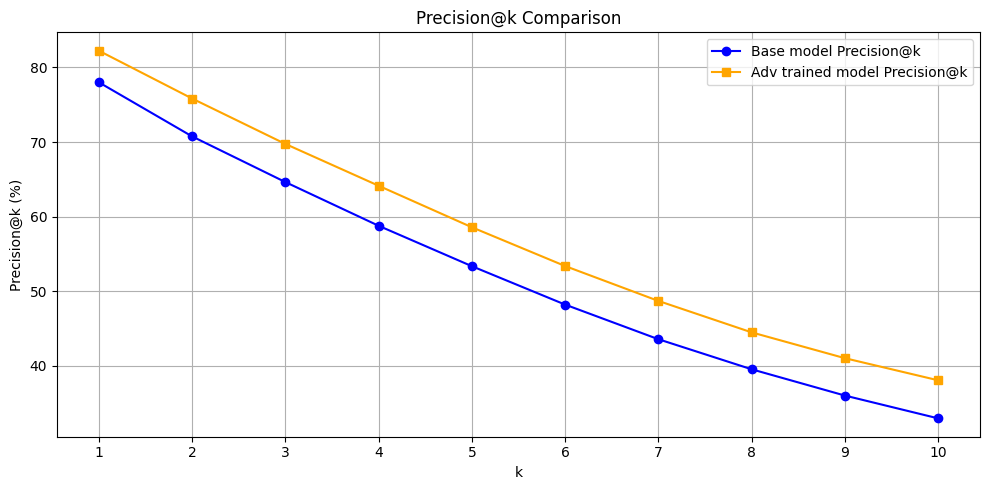

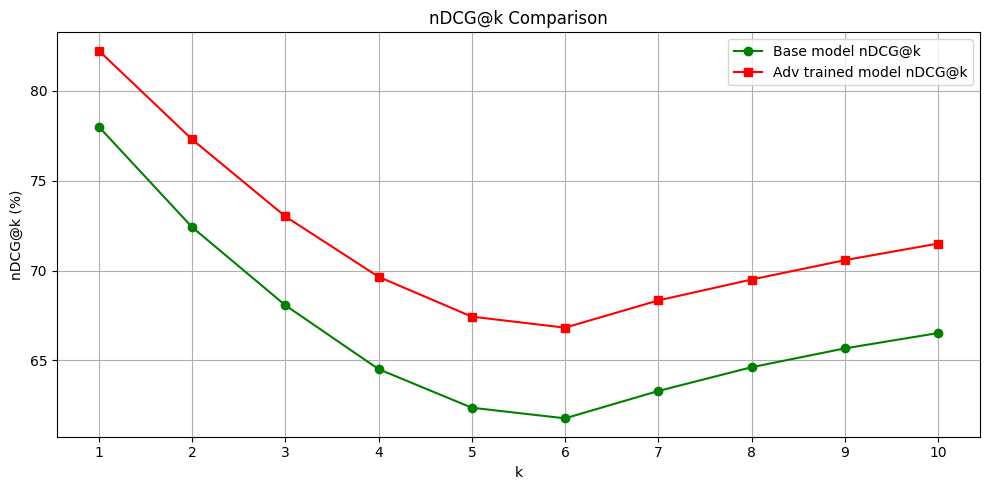

In [47]:
import matplotlib.pyplot as plt

base_precision_list = [avg_precision_base[k]*100 for k in range(1, 11)]
base_ndcg_list = [avg_ndcg_base[k]*100 for k in range(1, 11)]

# Adv model metrics
adv_precision = [avg_precision[k] * 100 for k in range(1, 11)]
adv_ndcg = [avg_ndcg[k]*100 for k in range(1, 11)]

k_values = list(range(1, 11))

# Precision@k Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, base_precision_list, marker='o', label='Base model Precision@k', color='blue')
plt.plot(k_values, adv_precision, marker='s', label='Adv trained model Precision@k', color='orange')
plt.xlabel('k')
plt.ylabel('Precision@k (%)')
plt.title('Precision@k Comparison')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# nDCG@k Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, base_ndcg_list, marker='o', label='Base model nDCG@k', color='green')
plt.plot(k_values, adv_ndcg, marker='s', label='Adv trained model nDCG@k', color='red')
plt.xlabel('k')
plt.ylabel('nDCG@k (%)')
plt.title('nDCG@k Comparison')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()